In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
from gplately import pygplates
from scipy import ndimage
from scipy.spatial import cKDTree

In [2]:
# agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/SampleData/Rasters/M2020_AgeGrids/"
# agegrid_filename = agegrid_dir + "Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"

agegrid_dir = "data/Clennet_AgeGrids_0.1d_masked/"
agegrid_filename = agegrid_dir+"seafloor_age_mask_{:.1f}Ma.nc"

reconstruction_times = np.arange(0,171)

# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, coastlines, continents, COBs, time=time)

In [ ]:
# overwrite with more recent reconstructions
input_directory = "../Slab-Dip/Notebooks/data/EarthByte_STELLAR_Plate_Motion_Model-Phase2/"
rotation_filenames = input_directory+'CombinedRotations.rot'
rotation_model = pygplates.RotationModel(rotation_filenames)

coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentsOnly.shp"
static_polygons = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.shp"
COBs = input_directory+"StaticGeometries/COBLineSegments/Global_EarthByte_GeeK07_COBLineSegments_2019_v1.shp"

topology_filenames = [
    input_directory+'Feature_Geometries.gpml',
    input_directory+'Plate_Boundaries.gpml'
]
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
# coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs, time=time)

agegrid_filename = input_directory+"EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-Paleomag-NC/"
agegrid_filename += "EarthByte_Plate_Motion_Model-Phase2-PaleomagneticReferenceFrame-{}.nc"
reconstruction_times = np.arange(0, 251)

In [3]:
def grad(raster, tol_grad=2, iter_dilation=0, mask=True, return_gradient=False):
    image = raster.fill_NaNs(return_array=True)
    gradX, gradY = np.gradient(image)
    gradXY = np.hypot(gradX, gradY)
    
    mask_fz = gradXY > tol_grad

    fz_grid = np.zeros(mask_fz.shape)
    fz_grid[mask_fz] = 1

    if iter_dilation:
        fz_grid = ndimage.binary_dilation(fz_grid, iterations=iter_dilation)
    
    if mask:
        fz_grid[np.isnan(raster.data)] = np.nan
        
    fz_raster = gplately.Raster(data=fz_grid, extent='global')    
    
    if return_gradient:
        return fz_raster, gradXY
    else:
        return fz_raster

In [4]:
def reconstruct_fracture_zones(time, return_grid=False, mask=False):
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    trench_norm = subduction_data[:,7]

    # store these for later
    subduction_lons = trench_lons.copy()
    subduction_lats = trench_lats.copy()
    
    dlon = -2.5*np.sin(np.radians(trench_norm))
    dlat = -2.5*np.cos(np.radians(trench_norm))
    
    trench_lons += dlon
    trench_lats += dlat
    
    agegrid_raster = gplately.Raster(filename=agegrid_filename.format(time))
    fz_raster, gradXY = grad(agegrid_raster, tol_grad=2, iter_dilation=0, mask=mask, return_gradient=True)
    mask_raster = fz_raster.data >= 1
    fz_raster.data[mask_raster] = gradXY[mask_raster]
    
    trench_fz = fz_raster.interpolate(trench_lons, trench_lats, method='nearest')
    
    # mask points where fracture zone intersects a subduction zone
    mask_trench_fz = trench_fz > 0
    trench_fz   = trench_fz[mask_trench_fz]
    trench_lons = subduction_lons[mask_trench_fz]
    trench_lats = subduction_lats[mask_trench_fz]
    
    if return_grid:
        return trench_lons, trench_lats, trench_fz, fz_raster.data
    else:
        return trench_lons, trench_lats, trench_fz

In [5]:
time = 40

fz_lons, fz_lats, fz_mag, fz_grid = reconstruct_fracture_zones(time, return_grid=True)

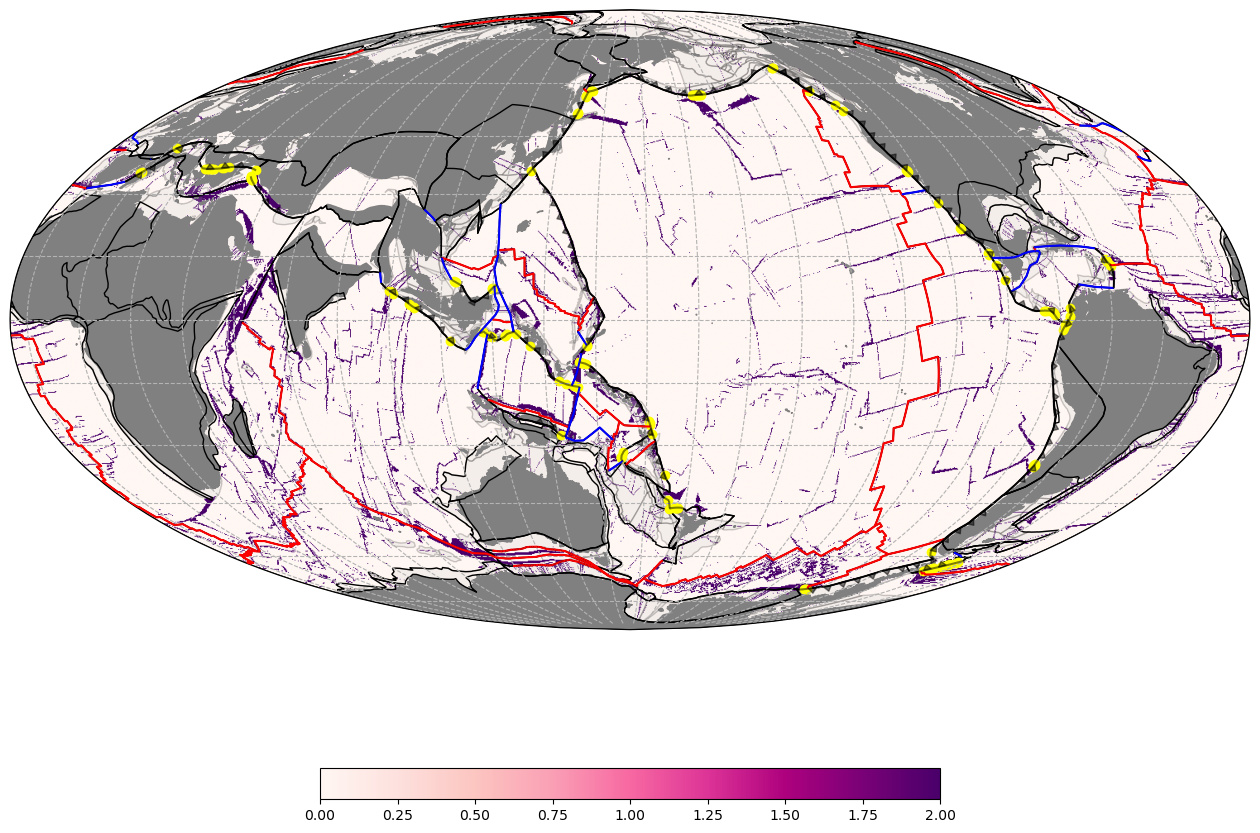

In [8]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = time # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
im = gplot.plot_grid(ax, fz_grid, origin='lower', cmap='RdPu', vmax=2)
gplot.plot_continents(ax, facecolor='0.8', alpha=0.2)
gplot.plot_coastlines(ax, facecolor='0.5', color='0.5')
gplot.plot_all_topologies(ax, color='k')
gplot.plot_ridges(ax, color='red', zorder=9)
gplot.plot_transforms(ax, color='b', zorder=9)

ax.scatter(fz_lons, fz_lats, c='yellow', transform=ccrs.PlateCarree())

# subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
# trench_lons = subduction_data[:,0]
# trench_lats = subduction_data[:,1]
# trench_norm = subduction_data[:,7]

# dlon = -2.5*np.sin(np.radians(trench_norm))
# dlat = -2.5*np.cos(np.radians(trench_norm))

# trench_lons += dlon
# trench_lats += dlat
# ax.scatter(trench_lons, trench_lats, c='b', transform=ccrs.PlateCarree())

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.5)

In [11]:
from joblib import Parallel, delayed

In [12]:
def save_and_reconstruct_fracture_zones(time):
    fz_lons, fz_lats, fz_mag, fz_grid = reconstruct_fracture_zones(time, return_grid=True, mask=True)
    fz_raster = gplately.Raster(fz_grid)
    fz_raster.save_to_netcdf4("output_grids/fz_grid_{:.0f}Ma.nc".format(time))
    return fz_lons, fz_lats, fz_mag

In [13]:
# Use LokyBackend to protect the netCDF routine
fz_data = Parallel(n_jobs=-3, backend='loky', verbose=1)\
(delayed(save_and_reconstruct_fracture_zones) (time,) for time in reconstruction_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.


PicklingError: Could not pickle the task to send it to the workers.

In [13]:
# initialise grid

age_raster = gplately.Raster(filename=agegrid_filename.format(0))

lonq, latq = np.meshgrid(np.linspace(-180,180,age_raster.data.shape[1]),
                         np.linspace(-90, 90, age_raster.data.shape[0]))

lonq_ = lonq.ravel()
latq_ = latq.ravel()

tree_fz = cKDTree(np.c_[lonq_, latq_])

In [14]:
# iterate through time series and interpolate to subducted grid

subducted_fz_grid      = np.zeros(age_raster.data.shape)
subducted_fz_time_grid = np.zeros(age_raster.data.shape)

for i, time in enumerate(reconstruction_times):
    fz_lons, fz_lats, fz_mag = fz_data[i]
    dist, neighbours = tree_fz.query(np.c_[fz_lons, fz_lats], k=9)
    for c in range(neighbours.shape[1]):
        subducted_fz_grid.flat[neighbours[:,c]] = fz_mag
        subducted_fz_time_grid.flat[neighbours[:,c]] = time
        

In [10]:
for i, time in enumerate(reconstruction_times):
    fz_lons, fz_lats, fz_grid = fz_data[i]
    _ , (row, col) = age_raster.interpolate(fz_lons, fz_lats, method='nearest', return_indices=True)
    subducted_fz_grid[row,col] += 1
    
# subducted_fz_grid[subducted_fz_grid == 0] = np.nan

NameError: name 'fz_data' is not defined

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


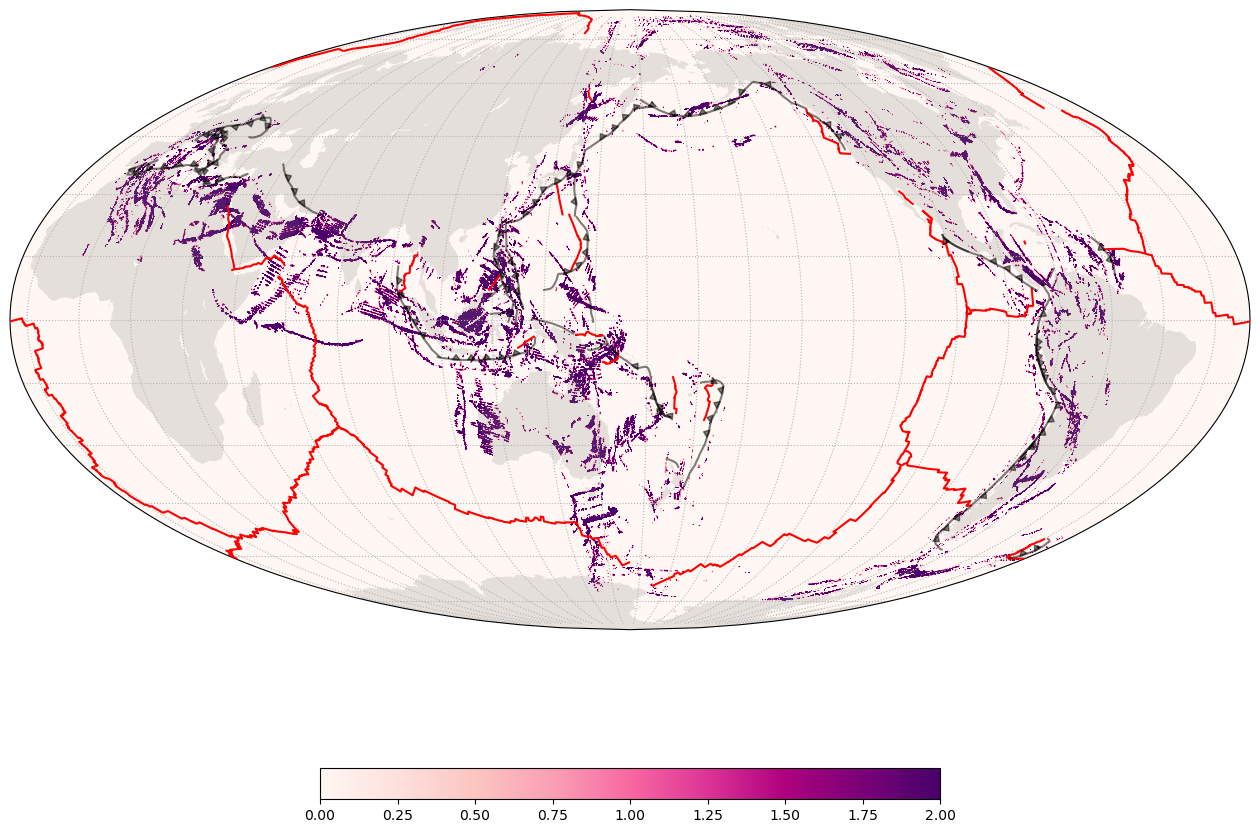

In [15]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
im = gplot.plot_grid(ax, subducted_fz_grid, origin='lower', cmap='RdPu', vmax=2)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)

fig.colorbar(im, shrink=0.5, orientation='horizontal')

In [24]:
# mask out zero regions
subducted_fz_time_grid2 = subducted_fz_time_grid.copy()

subducted_fz_time_grid2[subducted_fz_time_grid == 0] = np.nan

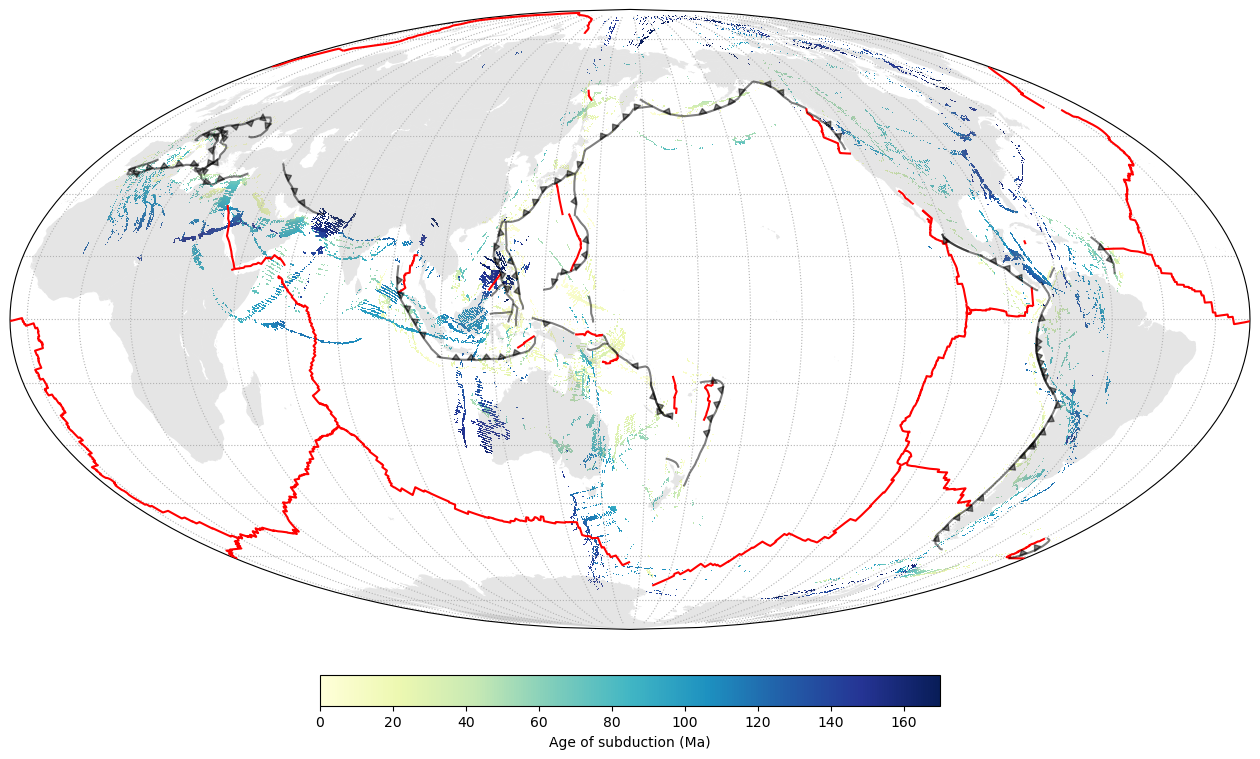

In [25]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
im = gplot.plot_grid(ax, subducted_fz_time_grid2, origin='lower', cmap='YlGnBu', interpolation='None', vmin=0)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)

fig.colorbar(im, shrink=0.5, pad=0.05, orientation='horizontal', label='Age of subduction (Ma)')

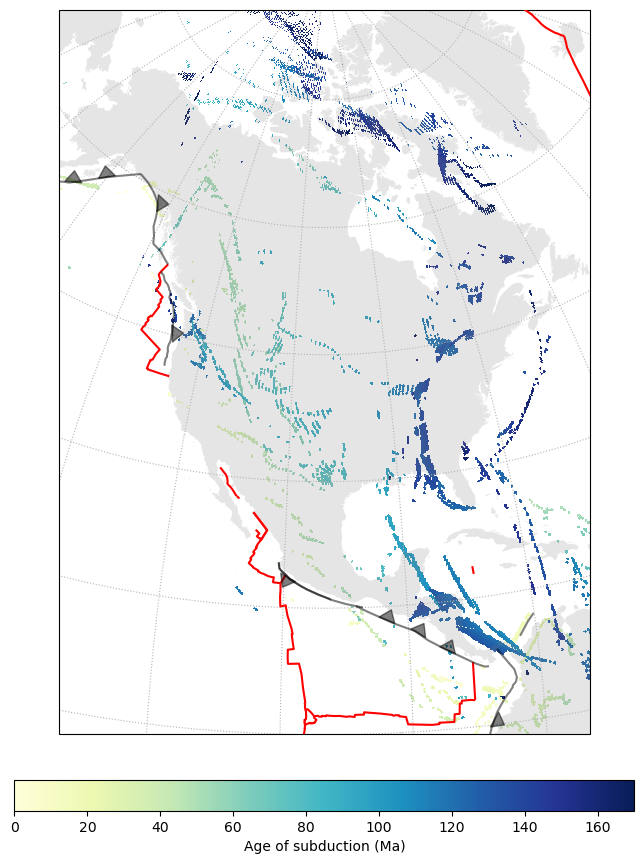

In [26]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.AzimuthalEquidistant(-100, 30))
ax.set_extent([-130, -70, 0, 85])
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
im = gplot.plot_grid(ax, subducted_fz_time_grid2, origin='lower', cmap='YlGnBu', interpolation='None', vmin=0)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)

fig.colorbar(im, shrink=0.5, pad=0.05, orientation='horizontal', label='Age of subduction (Ma)')

## Save data

In [27]:
subducted_grid = gplately.Raster(array=subducted_fz_time_grid2, extent='global')
subducted_grid.save_to_netcdf4('subducted_fz_ages.nc')

In [10]:
fz_data_dict = dict()

for i, time in enumerate(reconstruction_times):
    fz_data_dict[str(time)] = fz_data[i]
    
np.savez_compressed('subducted_fz_data.npz', **fz_data_dict)